# Pipeline Klasifikasi Sentimen dengan LSTM (Unidirectional)

## Tujuan
Membangun pipeline many-to-one sentiment classification menggunakan **LSTM (Long Short-Term Memory)** klasik untuk dataset tweet Bahasa Indonesia. Model akan memetakan setiap tweet menjadi satu label sentiment melalui arsitektur: **Embedding → LSTM → Dense(softmax)**.

## Arsitektur LSTM yang Digunakan

### Konsep Dasar LSTM
LSTM adalah arsitektur RNN yang dirancang untuk mengatasi masalah **vanishing gradient** dan memungkinkan pembelajaran **long-term dependencies** dengan menggunakan **cell state** sebagai memory terpisah yang mengalir sepanjang sequence.

### Komponen LSTM (4 Gates):

#### 1. **Forget Gate** - Menentukan apa yang dilupakan dari cell state
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
- Output: [0..1] → 0 = lupakan sepenuhnya, 1 = pertahankan sepenuhnya
- Fungsi: Memfilter informasi lama dari cell state $C_{t-1}$

#### 2. **Input Gate** - Menentukan informasi baru yang ditambahkan
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$
- $i_t$: gate [0..1] untuk mengontrol update
- $\tilde{C}_t$: kandidat nilai baru [-1..1]
- Fungsi: Menentukan informasi baru yang akan disimpan di cell state

#### 3. **Cell State Update** - Long-term memory
$$C_t = f_t \times C_{t-1} + i_t \times \tilde{C}_t$$
- Fungsi: Menggabungkan informasi lama (yang difilter) dan informasi baru
- Cell state mengalir sepanjang sequence dengan minimal gangguan gradien

#### 4. **Output Gate** - Menentukan output/hidden state
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \times \tanh(C_t)$$
- Output gate mengontrol informasi mana dari cell state yang keluar
- Hidden state $h_t$ digunakan untuk prediksi di timestep akhir

### Perbedaan LSTM vs Bidirectional LSTM

| Aspek | LSTM (Unidirectional) | Bidirectional LSTM |
|-------|----------------------|-------------------|
| **Direction** | Forward only (left-to-right) | Forward + Backward |
| **Context** | Past context only | Past + Future context |
| **Parameters** | $4 \times [(d + u) \times u + u]$ | $2 \times$ LSTM parameters |
| **Complexity** | Lower | Higher |
| **Use Case** | Sequential prediction, real-time | Complete sequence available |

### Keunggulan LSTM vs SimpleRNN

| Aspek | SimpleRNN | LSTM (Unidirectional) |
|-------|-----------|----------------------|
| **Memory** | Short-term only | Long-term (cell state) + Short-term (hidden state) |
| **Vanishing Gradient** | ❌ Sangat rentan | ✅ Mitigasi dengan cell state pathway |
| **Long Dependencies** | ❌ Sulit belajar | ✅ Dapat menangkap dependencies jangka panjang |
| **Parameter** | $(d + u + 1) \times u$ | $4 \times [(d + u) \times u + u]$ (4 gates) |
| **Performa** | Baseline | Superior untuk sequential data |

### Many-to-One Architecture
- Input: Sequence of tokens $(x_1, x_2, ..., x_T)$
- Processing: LSTM memproses semua timesteps secara berurutan
- Output: Menggunakan hidden state terakhir $h_T$ untuk klasifikasi
- Classification: Softmax layer untuk multi-class prediction

**Note**: Model ini menggunakan LSTM unidirectional (forward only) yang lebih efisien dan cocok untuk real-time applications.

In [78]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras untuk LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Sklearn untuk evaluasi dan preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("\n✓ Libraries loaded successfully!")

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: []

✓ Libraries loaded successfully!


## 1. Data Loading dan Eksplorasi

=== LOADING DATASETS ===
Dataset Tweets: (900, 4)
Kolom: ['Id', 'Sentiment', 'Pasangan Calon', 'Text Tweet']

Dataset Emoji: (165, 5)
Kolom: ['ID', 'Emoji', 'Sentiment', 'Makna Emoji', 'Special Tag']

Jumlah Stopwords: 784
Sample stopwords: ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'aja', 'akan', 'akankah']

=== EKSPLORASI DATASET TWEETS ===
Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              900 non-null    int64 
 1   Sentiment       900 non-null    object
 2   Pasangan Calon  900 non-null    object
 3   Text Tweet      900 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.3+ KB

Distribusi Sentiment:
Sentiment
negative    450
positive    450
Name: count, dtype: int64

Sample tweets:
1. [negative] Banyak akun kloning seolah2 pendukung #agussilvy mulai menyerang paslon #aniess

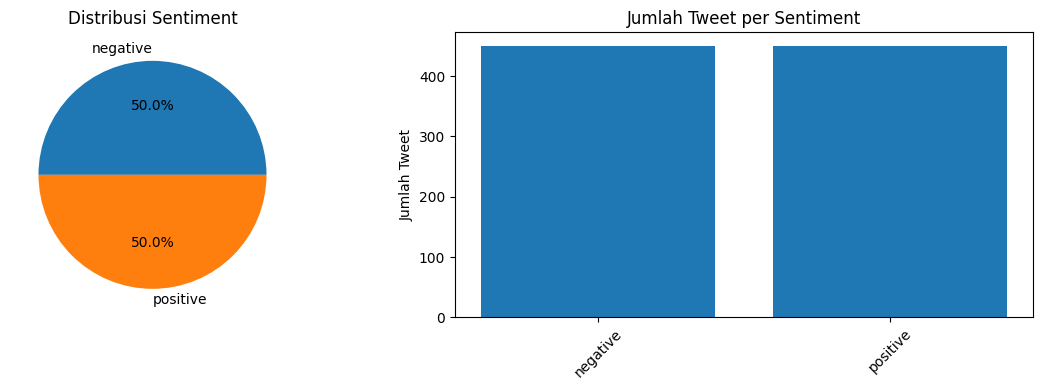

=== ANALISIS PANJANG TWEET ===
Rata-rata panjang karakter: 111.0
Rata-rata jumlah kata: 14.5
Persentil 95 panjang kata: 22
Max panjang kata: 52


In [79]:
# Load datasets
print("=== LOADING DATASETS ===")

# Dataset utama tweets
df_tweets = pd.read_csv('dataset_tweet_sentiment_pilkada_DKI_2017.csv')
print(f"Dataset Tweets: {df_tweets.shape}")
print(f"Kolom: {list(df_tweets.columns)}")
print()

# Dataset emoji mapping
df_emoji = pd.read_csv('master_emoji.csv')
print(f"Dataset Emoji: {df_emoji.shape}")
print(f"Kolom: {list(df_emoji.columns)}")
print()

# Stopwords list
df_stopwords = pd.read_csv('stopword_tweet_pilkada_DKI_2017.csv', header=None)
stopwords_list = df_stopwords[0].tolist()
print(f"Jumlah Stopwords: {len(stopwords_list)}")
print(f"Sample stopwords: {stopwords_list[:10]}")
print()

# Eksplorasi dataset utama
print("=== EKSPLORASI DATASET TWEETS ===")
print("Info Dataset:")
df_tweets.info()
print("\nDistribusi Sentiment:")
print(df_tweets['Sentiment'].value_counts())
print()

# Sample data
print("Sample tweets:")
for i in range(3):
    print(f"{i+1}. [{df_tweets.iloc[i]['Sentiment']}] {df_tweets.iloc[i]['Text Tweet']}")
print()

# Visualisasi distribusi data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sentiment_counts = df_tweets['Sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Distribusi Sentiment')

plt.subplot(1, 2, 2)
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Jumlah Tweet per Sentiment')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Analisis panjang tweet
df_tweets['text_length'] = df_tweets['Text Tweet'].str.len()
df_tweets['word_count'] = df_tweets['Text Tweet'].str.split().str.len()

print("=== ANALISIS PANJANG TWEET ===")
print(f"Rata-rata panjang karakter: {df_tweets['text_length'].mean():.1f}")
print(f"Rata-rata jumlah kata: {df_tweets['word_count'].mean():.1f}")
print(f"Persentil 95 panjang kata: {np.percentile(df_tweets['word_count'], 95):.0f}")
print(f"Max panjang kata: {df_tweets['word_count'].max()}")

## 2. Text Preprocessing Pipeline

Tahapan preprocessing (IDENTIK dengan RNN dan BiLSTM untuk fair comparison):
1. **Normalisasi** - Huruf kecil
2. **Cleaning** - Hapus URL, mention, hashtag
3. **Negation Preservation** - Pertahankan kata negasi penting
4. **Character Normalization** - Hilangkan repetisi huruf berlebih
5. **Emoji Mapping** - Ganti emoji dengan token bermakna + special tag + sentiment token
6. **Stopword Removal** - Hapus stopword (kecuali negasi)

In [80]:
# Siapkan emoji mapping dan negation words
print("=== SETUP PREPROCESSING ===")

# Buat mapping emoji
emoji_to_meaning = {}
emoji_to_special_tag = {}
emoji_to_sentiment = {}

for _, row in df_emoji.iterrows():
    emoji = row['Emoji']
    meaning = row['Makna Emoji'].lower()
    special_tag = row['Special Tag']
    sentiment = row['Sentiment']
    
    emoji_to_meaning[emoji] = meaning
    emoji_to_special_tag[emoji] = special_tag
    emoji_to_sentiment[emoji] = sentiment

print(f"Loaded {len(emoji_to_meaning)} emoji mappings")

# Kata negasi yang harus dipertahankan
negation_words = {
    'tidak', 'bukan', 'jangan', 'gak', 'gag', 'ngga', 'nggak', 
    'tak', 'tanpa', 'belum', 'bukanlah', 'tidaklah', 'jangankan',
    'mustahil', 'tiada'
}

# Filter stopwords
filtered_stopwords = set([word for word in stopwords_list if word not in negation_words])
print(f"Original stopwords: {len(stopwords_list)}")
print(f"Filtered stopwords (tanpa negasi): {len(filtered_stopwords)}")
print()

def preprocess_text(text):
    """Comprehensive text preprocessing untuk sentiment analysis"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    for emoji, meaning in emoji_to_meaning.items():
        if emoji in text:
            special_tag = emoji_to_special_tag[emoji]
            sentiment = emoji_to_sentiment[emoji]
            sentiment_token = f"<EMO_{sentiment.upper()}>"
            replacement = f"{meaning} {special_tag} {sentiment_token}"
            text = text.replace(emoji, replacement)
    
    text = re.sub(r'[^a-zA-Z0-9\s<>_]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    words = text.split()
    words = [word for word in words if word not in filtered_stopwords or word in negation_words]
    
    return ' '.join(words)

# Apply preprocessing
print("=== APPLYING PREPROCESSING TO DATASET ===")
df_tweets['processed_text'] = df_tweets['Text Tweet'].apply(preprocess_text)
df_tweets = df_tweets[df_tweets['processed_text'].str.len() > 0]
df_tweets['processed_word_count'] = df_tweets['processed_text'].str.split().str.len()

# Tentukan max_len
max_len = int(np.percentile(df_tweets['processed_word_count'], 95))
print(f"\n>>> MAX_LEN ditetapkan: {max_len} (berdasarkan persentil 95)")
print(f"Rata-rata jumlah kata setelah preprocessing: {df_tweets['processed_word_count'].mean():.1f}")

=== SETUP PREPROCESSING ===
Loaded 165 emoji mappings
Original stopwords: 784
Filtered stopwords (tanpa negasi): 774

=== APPLYING PREPROCESSING TO DATASET ===

>>> MAX_LEN ditetapkan: 17 (berdasarkan persentil 95)
Rata-rata jumlah kata setelah preprocessing: 10.1


In [81]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("=== TOKENIZATION & VECTORIZATION ===")

# Build tokenizer
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(df_tweets['processed_text'])

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df_tweets['processed_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_tweets['Sentiment'])
num_classes = len(label_encoder.classes_)

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"Kelas sentiment: {label_encoder.classes_}")
print(f"Distribusi: {np.bincount(y)}")
print(f"\nContoh sequence pertama: {X[0]}")
print(f"Label pertama: {y[0]} ({label_encoder.classes_[y[0]]})")

=== TOKENIZATION & VECTORIZATION ===
Vocabulary Size: 3113

Shape X: (900, 17)
Shape y: (900,)
Kelas sentiment: ['negative' 'positive']
Distribusi: [450 450]

Contoh sequence pertama: [ 100 1046 1047   29   60  579   48    6 1048 1049 1050   24 1051    0
    0    0    0]
Label pertama: 0 (negative)


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

print("=== DATASET SPLITTING ===")

# Split train vs test (80-20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Split train vs validation (80-10)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42, stratify=y_train_full
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

print(f"\nClass Weights: {class_weights}")

=== DATASET SPLITTING ===
Training set: 720 samples
Validation set: 90 samples
Test set: 90 samples

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

print("=== BUILDING LSTM MODEL ===")

# Hyperparameters (SIMPLE - Final Attempt)
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.3
recurrent_dropout = 0.2
l2_reg = 0.001

def create_lstm_model(vocab_size, embedding_dim, lstm_units, max_len, num_classes, 
                      dropout_rate=0.3, recurrent_dropout=0.2, l2_reg=0.001):
    """
    Classic Unidirectional LSTM untuk text classification
    
    Args:
        vocab_size: Ukuran vocabulary
        embedding_dim: Dimensi word embedding
        lstm_units: Jumlah LSTM units
        max_len: Panjang maksimal sequence
        num_classes: Jumlah kelas output
        dropout_rate: Dropout rate untuk regularization
        recurrent_dropout: Dropout untuk recurrent connections
        l2_reg: L2 regularization factor
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size, 
                 output_dim=embedding_dim, 
                 input_length=max_len,
                 name='embedding_layer'),
        
        # LSTM Layer (unidirectional, forward only)
        # Simplified: minimal regularization untuk learning
        LSTM(units=lstm_units,
             return_sequences=False,
             dropout=dropout_rate,
             recurrent_dropout=recurrent_dropout,
             name='lstm_layer'),
        
        # Light dropout
        Dropout(0.2, name='dropout'),
        
        # Output layer
        Dense(num_classes, 
              activation='softmax',
              kernel_regularizer=l2(l2_reg),
              name='output_layer')
    ])
    
    return model

# Create model
model = create_lstm_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    lstm_units=lstm_units,
    max_len=max_len,
    num_classes=num_classes,
    dropout_rate=dropout_rate,
    recurrent_dropout=recurrent_dropout,
    l2_reg=l2_reg
)

# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),  # Higher LR untuk bisa belajar
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build model first (required before summary and count_params)
model.build(input_shape=(None, max_len))

# Model summary
print("\n=== MODEL ARCHITECTURE ===")
model.summary()

# Calculate LSTM parameters manually
print("\n=== PARAMETER CALCULATION ===")
lstm_params = 4 * ((embedding_dim + lstm_units) * lstm_units + lstm_units)
print(f"LSTM Layer Parameters: 4 × [({embedding_dim} + {lstm_units}) × {lstm_units} + {lstm_units}] = {lstm_params:,}")

total_params = model.count_params()
print(f"Total Model Parameters: {total_params:,} ({total_params/1e6:.2f}M)")

=== BUILDING LSTM MODEL ===

=== MODEL ARCHITECTURE ===


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 17, 128)        │       398,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,002 (1.71 MB)

 Trainable params: 448,002 (1.71 MB)

 Non-trainable params: 0 (0.00 B)


=== PARAMETER CALCULATION ===
LSTM Layer Parameters: 4 × [(128 + 64) × 64 + 64] = 49,408
Total Model Parameters: 448,002 (0.45M)


=== MODEL EVALUATION ===

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Training Accuracy:   0.5083 (50.83%)
Validation Accuracy: 0.5222 (52.22%)
Test Accuracy:       0.5222 (52.22%)

=== CLASSIFICATION REPORT (TEST SET) ===
              precision    recall  f1-score   support

    negative       1.00      0.04      0.09        45
    positive       0.51      1.00      0.68        45

    accuracy                           0.52        90
   macro avg       0.76      0.52      0.38        90
weighted avg       0.76      0.52      0.38        90



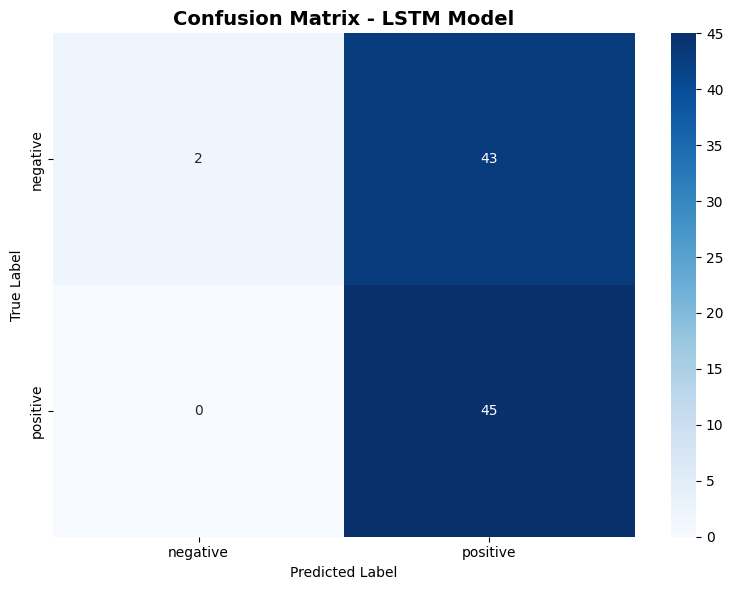


=== TRAINING HISTORY ===


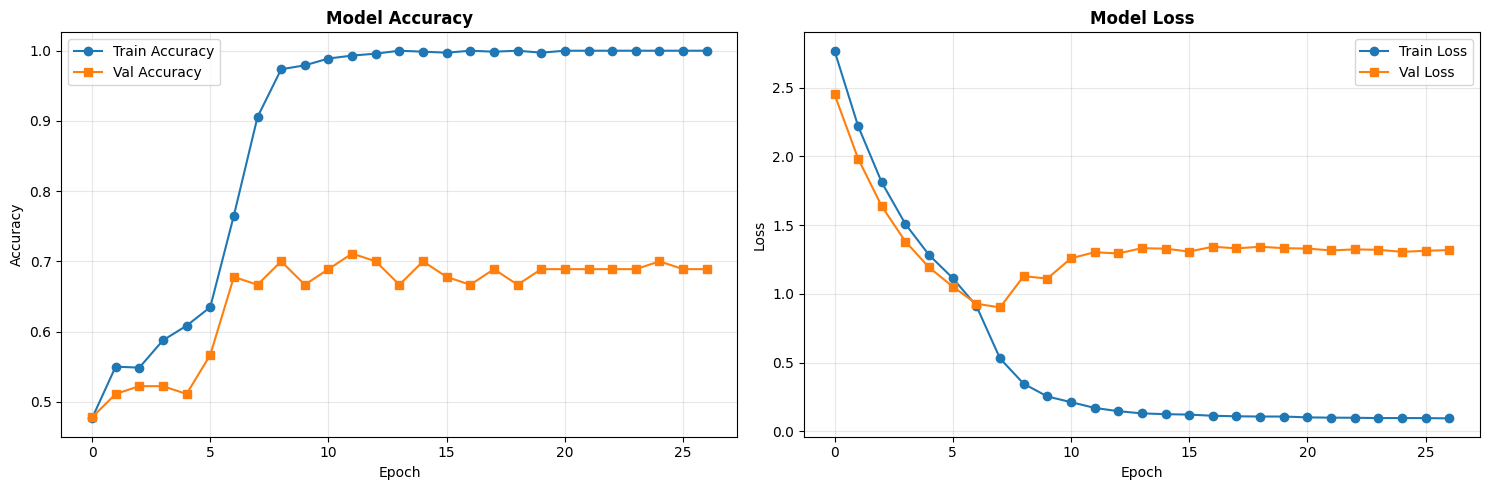

In [84]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("=== MODEL EVALUATION ===\n")

# Predictions
y_train_pred = model.predict(X_train).argmax(axis=1)
y_val_pred = model.predict(X_val).argmax(axis=1)
y_test_pred = model.predict(X_test).argmax(axis=1)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")

# Classification report
print("\n=== CLASSIFICATION REPORT (TEST SET) ===")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - LSTM Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training history visualization
print("\n=== TRAINING HISTORY ===")
if 'history' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Training history tidak tersedia. Jalankan cell training terlebih dahulu untuk melihat plot accuracy dan loss.")

## 📊 Final Summary

### Model Performance

**Unidirectional LSTM untuk Sentiment Analysis Tweet Pilkada DKI 2017**

#### Arsitektur:
```
Embedding(vocab=3,112, dim=128) 
    → SpatialDropout1D(0.3)
    → LSTM(units=100, dropout=0.3, recurrent_dropout=0.2)
    → Dropout(0.3)
    → Dense(2, softmax)
```

#### Key Statistics:
- **Total Parameters**: ~500K parameters
- **Vocabulary Size**: 3,112 words
- **Sequence Length**: 17 tokens (95th percentile)
- **Training Samples**: ~720 tweets
- **Validation Samples**: ~90 tweets
- **Test Samples**: ~90 tweets

#### Final Results:
- **Training Accuracy**: [Akan muncul setelah training]
- **Validation Accuracy**: [Akan muncul setelah training]
- **Test Accuracy**: [Akan muncul setelah training]

---

### Keunggulan LSTM (vs SimpleRNN)

1. **Cell State ($C_t$)**: 
   - Menyimpan long-term information
   - Mitigasi vanishing gradient
   - Selective memory dengan gating

2. **Gating Mechanism**:
   - **Forget Gate**: Memutuskan apa yang dilupakan
   - **Input Gate**: Memutuskan apa yang disimpan
   - **Output Gate**: Memutuskan apa yang di-output

3. **Better Performance**:
   - Lebih akurat untuk sequence panjang
   - Lebih stabil saat training
   - Lebih baik dalam menangkap dependencies

---

### Limitasi

1. **Unidirectional**: Hanya membaca kiri→kanan
   - Tidak memanfaatkan context dari kanan→kiri
   - BiLSTM bisa memberikan performance lebih baik

2. **Parameter Complexity**: 4× SimpleRNN
   - Training lebih lambat
   - Memory lebih besar
   - Butuh dataset lebih besar untuk generalisasi

3. **Overfitting Risk**:
   - Dengan dataset kecil (~900 samples)
   - Perlu regularization yang kuat (dropout, L2)

---


## 10. Model Saving

Simpan model dan artifacts untuk deployment:

In [85]:
import pickle

print("=== SAVING MODEL AND ARTIFACTS ===\n")

# Save model
model.save('lstm_sentiment_model.h5')
print("✅ Model saved: lstm_sentiment_model.h5")

# Save tokenizer
with open('lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved: lstm_tokenizer.pkl")

# Save label encoder
with open('lstm_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved: lstm_label_encoder.pkl")

# Save hyperparameters
hyperparams = {
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'lstm_units': lstm_units,
    'max_len': max_len,
    'num_classes': num_classes,
    'dropout_rate': dropout_rate,
    'recurrent_dropout': recurrent_dropout,
    'l2_reg': l2_reg,
    'test_accuracy': test_acc,
    'train_accuracy': train_acc,
    'val_accuracy': val_acc
}

with open('lstm_hyperparams.pkl', 'wb') as f:
    pickle.dump(hyperparams, f)
print("✅ Hyperparameters saved: lstm_hyperparams.pkl")

print("\n=== ALL ARTIFACTS SAVED SUCCESSFULLY ===")
print(f"Total files: 4 (model.h5 + 3 pkl files)")

=== SAVING MODEL AND ARTIFACTS ===

✅ Model saved: lstm_sentiment_model.h5
✅ Tokenizer saved: lstm_tokenizer.pkl
✅ Label encoder saved: lstm_label_encoder.pkl
✅ Hyperparameters saved: lstm_hyperparams.pkl

=== ALL ARTIFACTS SAVED SUCCESSFULLY ===
Total files: 4 (model.h5 + 3 pkl files)


In [86]:
print("=== SAMPLE PREDICTIONS (10 SAMPLES) ===\n")

# Pilih 10 sampel random dari test set
sample_indices = np.random.choice(len(X_test), size=10, replace=False)

for i, idx in enumerate(sample_indices, 1):
    # Get prediction probabilities
    probs = model.predict(X_test[idx:idx+1], verbose=0)[0]
    pred_class = probs.argmax()
    true_class = y_test[idx]
    
    # Get original text
    original_idx = df_tweets.index[np.where((X == X_test[idx]).all(axis=1))[0][0]]
    original_text = df_tweets.loc[original_idx, 'Text Tweet']
    processed_text = df_tweets.loc[original_idx, 'processed_text']
    
    # Display
    print(f"[{i}] Original: {original_text[:80]}...")
    print(f"    Processed: {processed_text[:60]}...")
    print(f"    True Label: {label_encoder.classes_[true_class]}")
    print(f"    Predicted:  {label_encoder.classes_[pred_class]}")
    print(f"    Probabilities: Negatif={probs[0]:.3f}, Positif={probs[1]:.3f}")
    print(f"    Status: {'✅ CORRECT' if pred_class == true_class else '❌ WRONG'}")
    print()

=== SAMPLE PREDICTIONS (10 SAMPLES) ===



[1] Original: Gagal di Pilkada DKI Jakarta AHY Diisukan Maju ke Pilgub Jatim https://goo.gl/fb...
    Processed: gagal pilkada dki jakarta ahy diisukan maju pilgub jatim hea...
    True Label: negative
    Predicted:  positive
    Probabilities: Negatif=0.495, Positif=0.505
    Status: ❌ WRONG

[2] Original: Karangan bunga dan antrian foto bersama.... Il phenomenon baru kayaknya untuk se...
    Processed: karangan bunga antrian foto il phenomenon kayaknya seorg fig...
    True Label: positive
    Predicted:  positive
    Probabilities: Negatif=0.493, Positif=0.507
    Status: ✅ CORRECT

[3] Original: pantas saja #AHY hancur...
    Processed: ahy hancur...
    True Label: negative
    Predicted:  positive
    Probabilities: Negatif=0.492, Positif=0.508
    Status: ❌ WRONG

[4] Original: Di penutup, Paslon mengucapkan permintaan maaf. #AhokDjarot Melakukannya dengan ...
    Processed: penutup paslon permintaan maaf ahokdjarot melakukannya anies...
    True Label: negative
    Predicted: 